### This notebook is for research on the MIND paper from Tank lab-
- paper: https://www.biorxiv.org/content/10.1101/418939v2.full.pdf

### Goals 
1. Run some simulations from the MIND paper to replicate Figure 1
    - use the [RatInABox](https://github.com/TomGeorge1234/RatInABox) software to assist with simulations (at least for an agent trajectory, maybe more). Currently the RatInABox repository is located here: C:\Users\andrew\Documents\gitRepositories\RatInABox
2. Once I have a working model, try installing multiple environments in the same network of neurons, with the remapping performed in a few different ways. The different ways are listed below in the section "ideas to test". 

### Perspective
There is an open question in hippocampal neuroscience (I think...) about how spatial coding and recoding occurs. In particular, it is not known whether remapping is random and orthogonal, or constrained by intrinsic hippocampal architecture. I think it could be interesting and fruitful to combine a model of latent space (e.g., MIND) with simulated activity patterns based on experimentally-predicted assumptions about remapping and hippocampal architecture to learn how each assumptions affects the global manifold and each local manifold. 

### Ideas to Test
1. Losonczy lab - Geiller et al., 2021 - specific connection patterns between place cells and local inhibitory neurons
2. Spruston lab - The MEC/LEC anatomy - constrained inputs from MEC/LEC that are better than usual at driving plateau potentials


In [193]:
%load_ext autoreload
%autoreload 2

# Inclusions
import socket
import sys, os
if socket.gethostname()=='Andrews-MacBook-Pro.local':
    sys.path.append("/Users/landauland/Documents/GitHub/RatInABox")#os.path.join('C:/', 'Users','andrew','Documents','GitHub','RatInABox'))
else:
    sys.path.append(os.path.join('C:/', 'Users','andrew','Documents','gitRepositories','RatInABox'))

import time
import numpy as np
import numba as nb
import scipy
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
import mindAlgorithm1 as mind

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# box coordinates
def getBoxCoord(boxLength,spacing=1):
    if not isinstance(spacing,int):
        raise ValueError("Spacing must be an integer")
    if not isinstance(boxLength,int):
        raise ValueError("Spacing must be an integer")
    xpos,ypos = np.meshgrid(np.arange(0,boxLength,spacing),np.arange(0,boxLength,spacing))
    return xpos,ypos

# random centroid selection (so can easily switch between random modes...)
def randCentroid(boxLength):
    xc = np.random.randint(0,boxLength) #np.random.random() * boxLength
    yc = np.random.randint(0,boxLength) #np.random.random() * boxLength
    return xc,yc

# return gaussian variance given a desired FWHM
def fwhmVar(x):
    return x**2 / (8*np.log(2))

# create place map given a centroid, place width, and room coordinates
def getPlaceMap(xcenter,ycenter,xpos,ypos,placeWidth):
    placeVar = fwhmVar(placeWidth)
    numerator = -(xpos - xcenter)**2 -(ypos-ycenter)**2
    denominator = 2*placeVar
    return np.exp(numerator / denominator)

# generate grid cell firing pattern (using Monaco & Abbott, 2011)
def getGridMap(xcenter,ycenter,xpos,ypos,gridSpacing,gridAngle):
    theta = np.array([-np.pi/3, 0, np.pi/3])
    u = lambda theta : np.array([np.cos(theta), np.sin(theta)])
    spOffsets = np.stack((xpos-xcenter, ypos-ycenter),axis=2)
    scaleFactor = (4*np.pi)/(np.sqrt(3)*gridSpacing)
    cosArgument = np.array([np.cos(scaleFactor*np.sum(spOffsets*u(theta[i]-gridAngle),axis=2)) for i in range(len(theta))])
    return np.sum(cosArgument,axis=0)

In [10]:
# Generate and plot some place cells and grid cells
NP = 50 # number of place cells
NG = 50 # number of grid cells
boxLength = 88 # 88cm box length (square arena)

gNoiseAmp = 1/5 # noise standard deviation relative to signal standard deviation

placeWidth = 41.6 # place field with in cm (full-width at half-maximum of an isotropic gaussian function)
numGridModules = 4 # number of grid modules (in increasing scale)
gridExpansion = 1.3 # relative scale increase of each consecutive grid module

baseGridSpacing = 39.8 # cm
baseGridWidth = 27.4 # cm (full-width at half-maximum of an isotropic gaussian function)
# they have something in the methods about lattice angle progressing by 15 degrees in each module, but I think I want to randomize it fully...

In [11]:
xpos,ypos = getBoxCoord(boxLength) 

# Create Library of Place Cells
xcPlace,ycPlace = zip(*[randCentroid(boxLength) for _ in range(NP)]) # centroid
placeLibrary = np.array([getPlaceMap(xcPlace[n],ycPlace[n],xpos,ypos,placeWidth) for n in range(NP)])

# Create Library of Grid Cells
xcGrid,ycGrid = zip(*[randCentroid(boxLength) for _ in range(NG)]) # centroid
spGrid = tuple(baseGridSpacing * (gridExpansion**np.random.randint(0,numGridModules)) for _ in range(NG)) # grid spacing
agGrid = tuple(np.pi/3*np.random.random() for _ in range(NG)) # angle of lattice
gridLibrary = np.array([getGridMap(xcGrid[n],ycGrid[n],xpos,ypos,spGrid[n],agGrid[n]) for n in range(NG)])

# Sanity Check!!
print(f'Shape of place library is {np.shape(placeLibrary)}')
print(f'Shape of grid library is {np.shape(gridLibrary)}')

Shape of place library is (50, 88, 88)
Shape of grid library is (50, 88, 88)


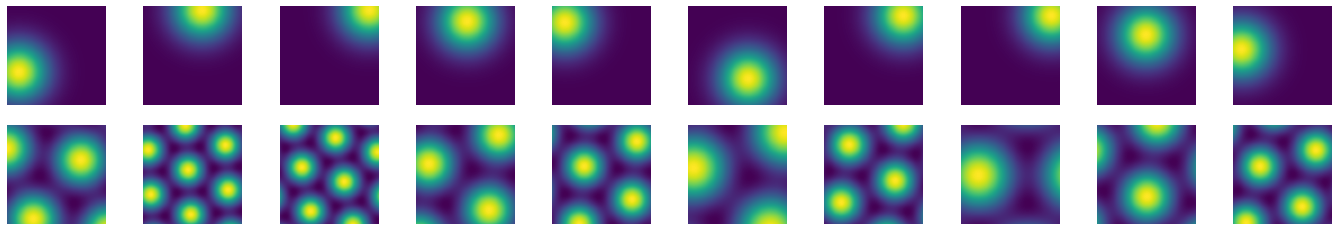

In [12]:
# Show Examples
numExamplesEach = 10
f, ax = plt.subplots(2,numExamplesEach,figsize=(24,4))
for n in range(numExamplesEach):
    ax[0,n].imshow(placeLibrary[np.random.randint(NP)])
    ax[1,n].imshow(gridLibrary[np.random.randint(NG)])
    ax[0,n].axis('off')
    ax[1,n].axis('off')

In [13]:
# Generate a trajectory in the environment
Env = Environment({"scale":boxLength/100}) # (RatInABox uses meters)
Ag = Agent(Env,{'dt':0.1})
for i in range(int(4000/Ag.dt)):
    Ag.update();

# Get trajectory variables
t, pos = np.array(Ag.history["t"]), np.array(Ag.history["pos"])
pos = pos * 100 # convert back to centimeters (to use as index)
posidx = np.floor(pos).astype('int8')

# Return place and grid cell activity along trajectory
placeActivity = placeLibrary[:,posidx[:,0],posidx[:,1]]
gridActivity = gridLibrary[:,posidx[:,0],posidx[:,1]]
hpcActivity = np.concatenate((placeActivity,gridActivity),axis=0)

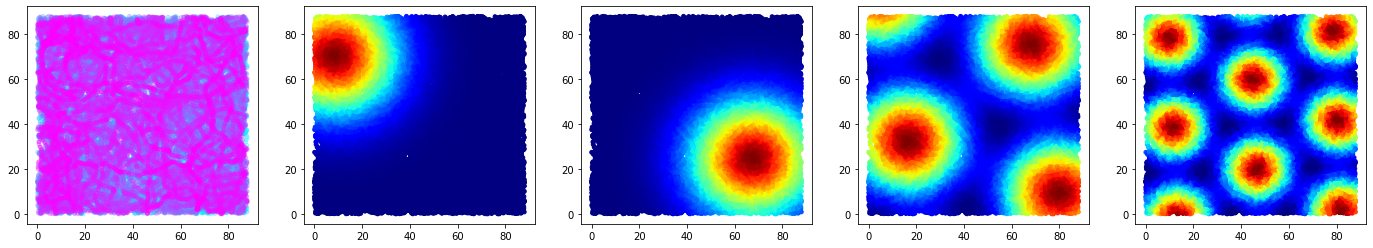

In [14]:
# Plot Trajectory and plot examples of place cell and grid cell activity overlaid on trajectory
numExamplesEach = 2
pexidx = np.random.randint(0,NP,numExamplesEach)
gexidx = np.random.randint(0,NG,numExamplesEach)
f, ax = plt.subplots(1,numExamplesEach*2+1,figsize=(24,4))
# Ag.plot_trajectory(ax=ax[0])
plt.set_cmap('cool')
ax[0].scatter(pos[:,0],pos[:,1],s=15,c=range(pos.shape[0]),alpha=0.3)
plt.set_cmap('jet')
for n in range(numExamplesEach):
    ax[n+1].scatter(pos[:,0],pos[:,1],s=15,c=placeActivity[pexidx[n],:])
    ax[n+1+numExamplesEach].scatter(pos[:,0],pos[:,1],s=15,c=gridActivity[gexidx[n],:])

## Checkpoint 1:
Now we have simulated hippocampal data, including place fields, grid cells, and a realistic trajectory. 

Next: create random forest PPCA model of the data

In [15]:
# Compute PPCA models of place activity, grid activity, and full hippocampal activity. Used for PCA dimensionality reduction
t = time.time()
lPlace,uPlace,covPlace,nvPlace,wPlace,vPlace = mind.ppca(placeActivity.T)
lGrid,uGrid,covGrid,nvGrid,wGrid,vGrid = mind.ppca(gridActivity.T)
lHPC,uHPC,covHPC,nvHPC,wHPC,vHPC = mind.ppca(hpcActivity.T)
print(f"Numpy finished in {time.time() - t} seconds")
print(f"-- Likelihood for ppca of place activity = {lPlace}, number of components required is {len(wPlace)}")
print(f"-- Likelihood for ppca of grid activity = {lGrid}, number of components required is {len(wGrid)}")
print(f"-- Likelihood for ppca of full HPC model = {lHPC}, and the number of components required for 95% of variance is: {len(wHPC)}")

# Convert activity to PCA scores
pfScores = vPlace.T @ (placeActivity - uPlace.reshape(-1,1))
hpcScores = vHPC.T @ (hpcActivity - uHPC.reshape(-1,1))

Numpy finished in 0.550300121307373 seconds
-- Likelihood for ppca of place activity = 2003112.9645031285, number of components required is 7
-- Likelihood for ppca of grid activity = -2068955.045412485, number of components required is 20
-- Likelihood for ppca of full HPC model = -1458281.2336604903, and the number of components required for 95% of variance is: 21


In [16]:
# Construct random forests for place activity and HPC activity (make 100 trees!)
numTrees = 1
nDir = 2
nLeaf = 100
nQuant = 10
placeForest = mind.constructForest(pfScores[:,:-1],pfScores[:,1:],numTrees=numTrees,nDir=nDir,nLeaf=nLeaf,nQuant=nQuant)
hpcForest = mind.constructForest(hpcScores[:,:-1],hpcScores[:,1:],numTrees=numTrees,nDir=nDir,nLeaf=nLeaf,nQuant=nQuant)

In [10]:
# For adding trees if necessary
# placeForest = mind.addTrees(pfScores[:,:-1],pfScores[:,1:],placeForest,50)
# hpcForest = mind.addTrees(hpcScores[:,:-1],hpcScores[:,1:],hpcForest,50)

In [17]:
# Summarize Forests (add item with all path structures, add PPCA models to top of forest)
mind.summarizeForest(placeForest)
mind.summarizeForest(hpcForest)

## Checkpoint 2:
Now we have a random forest PPCA model of the data (when I wrote this, I only have it for place activity and full HPC activity). Below, I plot the probability of transitioning to every grid point relative to some chosen starting point (using xC,yC) add plot it, to show that the forest learns which activity patterns are nearby in space to one another. 

In [18]:
# Compute probability of transitions from one point to all other possible points
xp4,yp4 = getBoxCoord(boxLength,4)
xpv = xp4.reshape(-1)
ypv = yp4.reshape(-1)
placeMesh = vPlace.T @ (placeLibrary[:,xpv,ypv] - uPlace.reshape(-1,1))
hpcMesh = vHPC.T @ (np.concatenate((placeLibrary[:,xpv,ypv],gridLibrary[:,xpv,ypv]),axis=0) - uHPC.reshape(-1,1))

xC,yC = 22,22
placeCenter = vPlace.T @ (placeLibrary[:,xC,yC].reshape(-1,1) - uPlace.reshape(-1,1))
hpcCenter = vHPC.T @ (np.concatenate((placeLibrary[:,xC,yC],gridLibrary[:,xC,yC]),axis=0).reshape(-1,1) - uHPC.reshape(-1,1))

In [21]:
placeMeshProb = mind.smartForestLikelihood(np.repeat(placeCenter.reshape(-1,1),placeMesh.shape[1],axis=1), placeMesh, placeForest)
hpcMeshProb = mind.smartForestLikelihood(np.repeat(hpcCenter.reshape(-1,1),hpcMesh.shape[1],axis=1), hpcMesh, hpcForest)

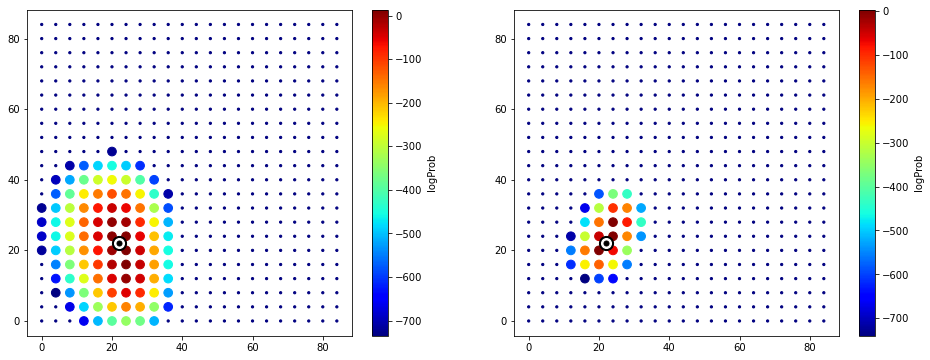

In [22]:
machineEps = np.finfo(float).eps
fig,ax = plt.subplots(1,2,figsize=(16,6))

placeNonzero = np.where(placeMeshProb != 0)[0]
placeZero = np.where(placeMeshProb == 0)[0]
cLimits = (np.min(np.log(placeMeshProb[placeNonzero])), np.max(np.log(placeMeshProb[placeNonzero])))
xx = ax[0].scatter(xpv[placeNonzero],ypv[placeNonzero],s=75,c=np.log(placeMeshProb[placeNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xpv[placeZero],ypv[placeZero],s=5,c=cLimits[0]*np.ones_like(xpv[placeZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xC,yC,s=200,c='k')
ax[0].scatter(xC,yC,s=100,c='w')
ax[0].scatter(xC,yC,s=25,c='k')
plt.colorbar(xx,ax=ax[0],label='logProb')

hpcNonzero = np.where(hpcMeshProb != 0)[0]
hpcZero = np.where(hpcMeshProb == 0)[0]
cLimits = (np.min(np.log(hpcMeshProb[hpcNonzero])), np.max(np.log(hpcMeshProb[hpcNonzero])))
xx = ax[1].scatter(xpv[hpcNonzero],ypv[hpcNonzero],s=75,c=np.log(hpcMeshProb[hpcNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xpv[hpcZero],ypv[hpcZero],s=5,c=cLimits[0]*np.ones_like(xpv[hpcZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xC,yC,s=200,c='k')
ax[1].scatter(xC,yC,s=100,c='w')
ax[1].scatter(xC,yC,s=25,c='k')
plt.colorbar(xx,ax=ax[1],label='logProb')

## Next Step: 
Now, we have to build a distance map across the dataset. As indicated in the biorxiv paper, they do this with "landmark" points, which are selected using a greedy min/max algorithm which starts with random points, then continues selecting each next point as the one furthest away from all others (from this paper: http://graphics.stanford.edu/courses/cs468-05-winter/Papers/Landmarks/Silva_landmarks5.pdf)

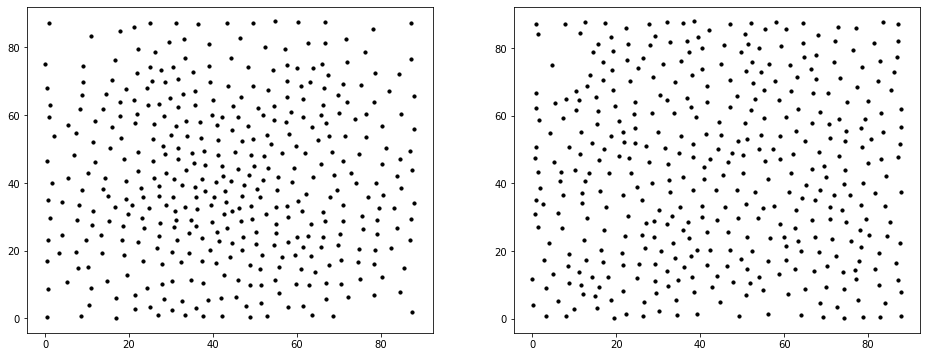

In [25]:
# Return landmark points and compute distance matrix with them
pfLandmark,pfLmIdx = mind.returnLandmarkPoints(pfScores,numLandmark=400,numSeed=1)
hpcLandmark,hpcLmIdx = mind.returnLandmarkPoints(hpcScores,numLandmark=400,numSeed=1)

fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(pos[pfLmIdx,0],pos[pfLmIdx,1],s=10,c='k')
ax[1].scatter(pos[hpcLmIdx,0],pos[hpcLmIdx,1],s=10,c='k');

In [26]:
# Compute pairwise transition probability between all landmark points
pfLmProb = mind.smartGridProbability(pfLandmark, placeForest)
hpcLmProb = mind.smartGridProbability(hpcLandmark, hpcForest)

# Normalize transition probabilities
pfLmProb = pfLmProb / np.sum(pfLmProb,axis=1)
hpcLmProb = hpcLmProb / np.sum(hpcLmProb,axis=1)

In [27]:
# Convert landmark transition probability into local distance metric 
pfLmLocalDist = mind.probabilityToDistance(pfLmProb)
hpcLmLocalDist = mind.probabilityToDistance(hpcLmProb)

# Convert local distance metric to global geodesic distance using Johnson's algorithm
pfLmGlobalDist = scipy.sparse.csgraph.johnson(pfLmLocalDist)
hpcLmGlobalDist = scipy.sparse.csgraph.johnson(hpcLmLocalDist)

# Symmetrize global distance
pfLmDist = (pfLmGlobalDist + pfLmGlobalDist.T)/2
hpcLmDist = (hpcLmGlobalDist + hpcLmGlobalDist.T)/2

/Users/landauland/Documents/GitHub/mindAlgorithm/mindAlgorithm1.py:354: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-distVector, out=distVector, where=distVector<np.inf)


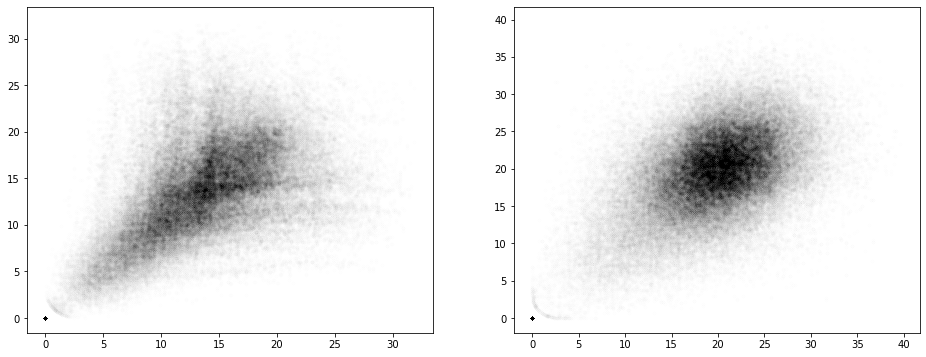

In [141]:
# This shows the comparison between D_ij and D_ji, which should be unity if it's really symmetric dynamics
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(pfLmGlobalDist,pfLmGlobalDist.T,c='k',s=10,alpha=0.002)
ax[1].scatter(hpcLmGlobalDist,hpcLmGlobalDist.T,c='k',s=10,alpha=0.002)

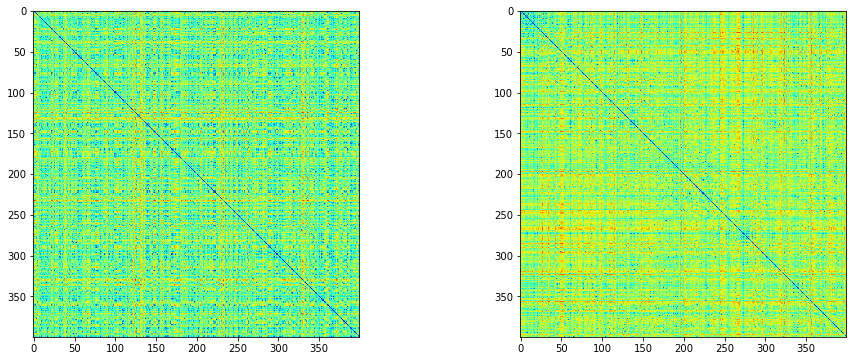

In [28]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].imshow(pfLmDist)
ax[1].imshow(hpcLmDist)

## Checkpoint 3:
Now we have a global distance metric for a subset of landmark points. This is used as a scaffold for the manifold. 

Next, we have to use the distance metric to learn intrinsic manifold coordinates for the landmark points. This uses the conjugate gradient method and corresponds to Sammon mapping. 

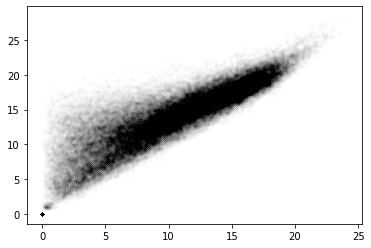

In [134]:
numDims = 2
placeCMDS = mind.initMDS(pfLmDist,numDims,method='fast')
hpcCMDS = mind.initMDS(hpcLmDist,numDims,method='fast')

pfDistCMDS = squareform(pdist(placeCMDS))

plt.scatter(pfDistCMDS[:],pfLmDist[:],s=10,c='k',alpha=0.002)

In [72]:
import inspect
print(os.path.abspath(inspect.getfile(MDS)))

/Users/landauland/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py


In [73]:
eeeDD = embedding.dissimilarity_matrix_

(100, 5)


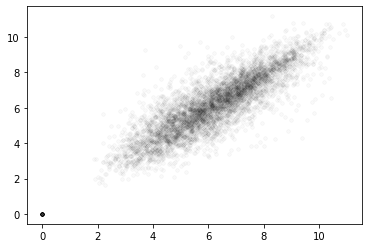

In [91]:
from sklearn.manifold import MDS as skMDS

NNN = 100
DDD = 20
xxx = np.random.normal(0,1,(NNN,DDD))
xxxDist = squareform(pdist(xxx))

numKeep = 5
CMDS = mind.cMDS(xxxDist,numKeep)
DMDS = mind.cMDS(xxxDist,numKeep)
print(CMDS.shape)

cccDist = squareform(pdist(CMDS))
dddDist = squareform(pdist(DMDS))

plt.scatter(cccDist, dddDist, s=15, c='k', alpha=0.01)

## Some other code I've used for testing various things 

In [162]:
from sklearn.datasets import make_spd_matrix as spd
xx = spd(500)
G = np.linalg.cholesky(xx)
print(f"Determinant: {np.linalg.det(xx)}")
print(f"SmartDet:    {(np.prod(np.diag(G)))**2}")
print(f"WeirdDet:    {np.exp(2*np.sum(np.log(np.diag(G))))}")
print(f"Log Determinant:   {np.log(np.linalg.det(xx))}")
print(f"Log Det Cholesky:  {2*np.log(np.linalg.det(G))}")
print(f"Log Smart Chol:    {2*np.log(np.prod(np.diag(G)))}")
print(f"Log Smarter Chol:  {2*np.sum(np.log(np.diag(G)))}")

Determinant: 2.1204785052493824e-215
SmartDet:    2.1204785150201225e-215
WeirdDet:    2.12047851502009e-215
Log Determinant:   -494.3041532204813
Log Det Cholesky:  -494.3041532158734
Log Smart Chol:    -494.3041532158735
Log Smarter Chol:  -494.3041532158735


In [ ]:
prob = np.random.randint(5, size=4) /4
print(prob)

result = np.where(prob > 0, prob, np.inf)
print(result)
np.log10(result, out=result, where=result > 0)
# -np.log(0)

[0. 1. 1. 1.]
[inf  1.  1.  1.]


array([inf,  0.,  0.,  0.])

In [9]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                   hpcActivity: 15.3 MiB
                     hpcScores:  3.2 MiB
                  placeLibrary:  3.0 MiB
                   gridLibrary:  3.0 MiB
                      pfScores:  1.1 MiB
                           pos: 312.6 KiB
                        covHPC: 78.2 KiB
                          xpos: 60.6 KiB
                          ypos: 60.6 KiB
                        posidx: 39.2 KiB


In [12]:
xxForest = mind.constructForest(pfScores[:,:-1],pfScores[:,1:],numTrees=1,nDir=2,nLeaf=50,nQuant=8)

In [13]:
mind.summarizeForest(xxForest)

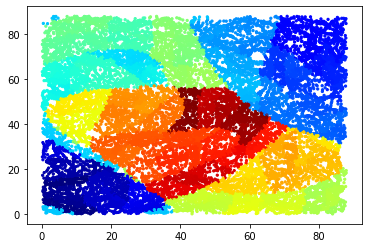

In [27]:
pathIndices = mind.returnPathIndexLoop(pfScores,xxForest['tree'][0])
plt.scatter(pos[:,0],pos[:,1],s=5,c=pathIndices)

In [179]:
import torch

In [183]:
torch.ones(3)

tensor([1., 1., 1.])

In [191]:
def smartLikelihoodParallel(data, u, iS, logDet, D): 
    udata = data - u
    expArgument = -(1/2) * np.einsum('nd,nnd,nd -> d', udata, iS, udata)
    logLikelihood = -D/2*np.log(2*np.pi) - 1/2*logDet + expArgument
    return np.exp(logLikelihood)

def smartLikelihood(data, u, iS, logDet, D): 
    udata = data - u
    expArgument = -(1/2) * (udata.reshape(1,-1) @ iS @ udata.reshape(-1,1))
    logLikelihood = -D/2*np.log(2*np.pi) - 1/2*logDet + expArgument
    return np.exp(logLikelihood)

In [192]:
import mindAlgorithm1_Optimization as mindOpt

N = 20
D = 100000
data = np.random.normal(0,1,(N,D))
u = np.zeros((N,D))
cv = np.repeat(np.identity(N).reshape(N,N,1),D,axis=2)
ld = np.ones(D)

t = time.time()
x = smartLikelihoodParallel(data, u, cv, ld, D)
print(f"Time parallel: {time.time()-t}")

t = time.time()
z = np.zeros(D)
for ii in range(D):
    z[ii] = smartLikelihood(data[:,ii], u[:,ii], cv[:,:,ii], ld[ii], N)
print(f"Time: {time.time()-t}")

print(np.allclose(x,z))

Time parallel: 0.008226871490478516
Time: 1.1229960918426514
True


In [163]:

x

array([19.24263571, 21.03256452, 21.73516124, ..., 19.30411296,
       20.87843249, 12.99909709])

In [157]:
data.shape

(20, 10000)

In [158]:
cv.shape

(20, 20, 10000)

In [159]:
ld.shape

(10000,)

In [160]:
x.shape

(10000,)